# Race Around the Netherlands 

### Main questions:
<ul>
<li> Who are tougher: men or women? </li>
<li> Are riders that ride together faster or slower? </li>
<li> How does rainfall and windspeed affect the riders?</li>
</ul>

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from datetime import datetime
%matplotlib inline

import pymysql
from sqlalchemy import create_engine

In [2]:
riders = pd.read_csv('./data/all_riders_concatenated.csv')
weather = pd.read_csv('./data/weather_excl_wind_dir.csv')

### CSV's to MYSQL-tables
 I already started working from the CSV, so proof of principle, but will continue with CSV

In [3]:
# engine = 'mysql+pymysql://root:123KLM@%GFDhello@localhost/ironhack_project2'

In [4]:
# riders.to_sql("riders", engine)
# weather.to_sql("weather", engine) 

In [5]:
# riders_sql = pd.read_sql_query('SELECT * FROM ironhack_project2.riders', engine)
# riders_sql.head()

# RIDER DATA CLEANING & WRANGLING

### Drop unnecessary columns and rows

The corona crisis affected which riders could travel to The Netherlands and were therefore able to show up at the start. In 2021 corona still played a role. Therefore we will not analyze riders that did not start (DNS). These can be removed from the file.

Also, columns: <i> Unnamed: 0 </i> and <i> Unnamed: 0.1 </i> can be removed.

In [6]:
riders.head(2)

,Unnamed: 0,Unnamed: 0.1,Place,Firstname,Lastname,Gender,Solo or Duo,Status,StartDate,Checkpoint_1,Checkpoint_2,Checkpoint_3,Checkpoint_4,Checkpoint_5,Checkpoint_6,Checkpoint_7,Checkpoint_8,Checkpoint_9,Checkpoint_fin
0,0,0,1,Joris,Cosyn,male,Solo,Finisher,2018-05-01 08:00:00,2018-05-01 13:38:00,2018-05-02 01:17:00,2018-05-02 05:22:00,2018-05-02 10:22:00,2018-05-02 16:02:00,2018-05-03 06:28:00,2018-05-03 11:36:00,2018-05-04 05:54:00,2018-05-04 19:20:00,2018-05-05 14:24:00
1,1,1,2,Tjerk,Bakker,male,Solo,Finisher,2018-05-01 08:00:00,2018-05-01 14:35:00,2018-05-02 09:15:00,2018-05-02 13:17:00,empty,2018-05-03 07:01:00,2018-05-03 14:34:00,2018-05-03 19:30:00,2018-05-04 16:03:00,2018-05-05 08:59:00,2018-05-05 18:48:00


In [7]:
#drop columns
riders = riders.drop(["Unnamed: 0", "Unnamed: 0.1"], axis = 1)

# delete rows of riders that did not start (status: DNS)
riders = riders[riders.Status != "DNS"]

In [8]:
riders.tail(5)

,Place,Firstname,Lastname,Gender,Solo or Duo,Status,StartDate,Checkpoint_1,Checkpoint_2,Checkpoint_3,Checkpoint_4,Checkpoint_5,Checkpoint_6,Checkpoint_7,Checkpoint_8,Checkpoint_9,Checkpoint_fin
304,2,NaN,van Rijswijk - van den Broek,mixed,Duo,Finisher,2021-04-30 08:15:00,2021-04-30 15:30:00,2021-05-01 16:16:00,2021-05-01 19:55:00,2021-05-02 16:42:00,2021-05-03 13:18:00,2021-05-05 09:40:00,2021-05-05 16:27:00,2021-05-07 13:39:00,2021-05-08 11:55:00,2021-05-09 15:30:00
305,999,NaN,Cullen - Driedonks,male,Duo,DNF,2021-05-01 06:15:00,2021-05-01 12:40:00,2021-05-02 00:59:00,2021-05-02 04:17:00,2021-05-02 18:46:00,empty,empty,empty,empty,empty,empty
306,999,NaN,Harder - Joosten,male,Duo,DNF,2021-04-30 08:15:00,2021-04-30 15:17:00,2021-05-01 11:53:00,2021-05-01 16:03:00,2021-05-02 11:59:00,2021-05-02 21:57:00,empty,empty,empty,empty,empty
307,999,NaN,Bisschops - Wiegel,mixed,Duo,DNF,2021-04-30 06:30:00,2021-04-30 13:53:00,2021-05-01 11:39:00,2021-05-01 16:00:00,2021-05-02 10:25:00,2021-05-02 21:13:00,empty,empty,empty,empty,empty
308,999,NaN,Verweij - Hoskam,mixed,Duo,DNF,2021-04-30 08:15:00,2021-04-30 14:27:00,2021-05-01 12:38:00,2021-05-01 15:38:00,2021-05-02 11:14:00,empty,empty,empty,empty,empty,empty


### Calculate after how many checkpoints the riders that did not finish dropped

In [9]:
pd.set_option('display.max_rows', riders.shape[0]+1)
riders = riders.reset_index()

In [10]:
#add a column that counts after how many checkpoints a rider gave up (if he/she did)

# find out at which checkpoint the rider is last seen and put that in a list which will be appended to the riders dataframe.
# find out at which data/time the rider is last seen and put that in a list which will be appended to the riders dataframe.  

count = [] #checkpoint the riders is last seen (start = 0)
last_time = [] #last datetime that is noted for the riders

for i in range(len(riders)):
    if riders["Checkpoint_fin"][i] != "empty": #these riders finished the ride
        left_race = 10
        count.append(left_race)
        time = riders["Checkpoint_fin"][i]
        last_time.append(time)
#        print(f'great news at {[i]}', left_race)
    elif riders["Checkpoint_9"][i] != "empty":
        left_race = 9
        count.append(left_race)
        time = riders["Checkpoint_9"][i]
        last_time.append(time)
#        print(f'great news at {[i]}', left_race)
    elif riders["Checkpoint_8"][i] != "empty":
        left_race = 8
        count.append(left_race)
        time = riders["Checkpoint_8"][i]
        last_time.append(time)
#        print(f'great news at {[i]}', left_race)
    elif riders["Checkpoint_7"][i] != "empty":
        left_race = 7
        count.append(left_race)
        time = riders["Checkpoint_7"][i]
        last_time.append(time)
#        print(f'great news at {[i]}', left_race)
    elif riders["Checkpoint_6"][i] != "empty":
        left_race = 6 
        count.append(left_race)
        time = riders["Checkpoint_6"][i]
        last_time.append(time)
#        print(f'great news at {[i]}', left_race)
    elif riders["Checkpoint_5"][i] !="empty":
        left_race = 5
        count.append(left_race)
        time = riders["Checkpoint_5"][i]
        last_time.append(time)
#        print(f'great news at {[i]}', left_race)
    elif riders["Checkpoint_4"][i] != "empty":
        left_race = 4
        count.append(left_race)
        time = riders["Checkpoint_4"][i]
        last_time.append(time)
#        print(f'great news at {[i]}', left_race)
    elif riders["Checkpoint_3"][i] != "empty":
        left_race = 3
        count.append(left_race)
        time = riders["Checkpoint_3"][i]
        last_time.append(time)
#        print(f'great news at {[i]}', left_race)
    elif riders["Checkpoint_2"][i] != "empty":
        left_race = 2
        count.append(left_race)
        time = riders["Checkpoint_2"][i]
        last_time.append(time)
#        print(f'great news at {[i]}', left_race)
    elif riders["Checkpoint_1"][i] != "empty":
        left_race = 1
        count.append(left_race)
        time = riders["Checkpoint_1"][i]
        last_time.append(time)
#       print(f'great news at {[i]}', left_race)
    elif riders["Checkpoint_1"][i] == "empty":
        left_race = 0
        count.append(left_race)
        time = riders["StartDate"][i]
        last_time.append(time)
#        print(f'great news at {[i]}', left_race)
    else:
        print(f'problem at line {[i]}')       


In [11]:
# last_time 

In [12]:
riders["Last_seen_place"] = count
riders["Last_seen_date"] = last_time

In [13]:
riders.head()

,index,Place,Firstname,Lastname,Gender,Solo or Duo,Status,StartDate,Checkpoint_1,Checkpoint_2,Checkpoint_3,Checkpoint_4,Checkpoint_5,Checkpoint_6,Checkpoint_7,Checkpoint_8,Checkpoint_9,Checkpoint_fin,Last_seen_place,Last_seen_date
0,0,1,Joris,Cosyn,male,Solo,Finisher,2018-05-01 08:00:00,2018-05-01 13:38:00,2018-05-02 01:17:00,2018-05-02 05:22:00,2018-05-02 10:22:00,2018-05-02 16:02:00,2018-05-03 06:28:00,2018-05-03 11:36:00,2018-05-04 05:54:00,2018-05-04 19:20:00,2018-05-05 14:24:00,10,2018-05-05 14:24:00
1,1,2,Tjerk,Bakker,male,Solo,Finisher,2018-05-01 08:00:00,2018-05-01 14:35:00,2018-05-02 09:15:00,2018-05-02 13:17:00,empty,2018-05-03 07:01:00,2018-05-03 14:34:00,2018-05-03 19:30:00,2018-05-04 16:03:00,2018-05-05 08:59:00,2018-05-05 18:48:00,10,2018-05-05 18:48:00
2,2,3,Colin,James,male,Solo,Finisher,2018-05-01 08:00:00,2018-05-01 14:08:00,2018-05-02 08:32:00,2018-05-02 11:53:00,2018-05-02 16:51:00,2018-05-03 04:11:00,2018-05-03 12:32:00,2018-05-03 17:34:00,2018-05-04 12:10:00,2018-05-05 07:54:00,2018-05-05 19:22:00,10,2018-05-05 19:22:00
3,3,4,Jason,Schreurs,male,Solo,Finisher,2018-05-01 08:00:00,2018-05-01 13:27:00,2018-05-02 10:08:00,2018-05-02 12:52:00,2018-05-02 17:36:00,2018-05-03 08:16:00,2018-05-03 14:51:00,2018-05-03 19:30:00,2018-05-04 16:35:00,2018-05-05 11:05:00,2018-05-05 21:30:00,10,2018-05-05 21:30:00
4,4,5,Erik,Wallinga,male,Solo,Finisher,2018-05-01 08:00:00,2018-05-01 14:25:00,2018-05-02 04:13:00,2018-05-02 07:50:00,2018-05-02 13:42:00,2018-05-02 20:00:00,2018-05-03 14:13:00,2018-05-03 18:40:00,2018-05-04 20:22:00,2018-05-05 09:53:00,2018-05-05 22:39:00,10,2018-05-05 22:39:00


### Calculate how much time each stretch took

calculate how long riders do over each stretch. Stretch_1 = Start to Checkpoint 1; stretch_2 = checkpoint1 to checkpoint2 etc

In [14]:
#convert StartDate and all Checkpoints to datetime

for i in range(len(riders)):
    if riders["StartDate"][i] != "empty":
        riders["StartDate"][i] = pd.to_datetime(riders["StartDate"][i], format='%Y-%m-%d %H:%M:%S')
    else:
        riders["StartDate"][i] = riders["StartDate"][i]


for i in range(len(riders)):
    if riders["Checkpoint_1"][i] != "empty":
        riders["Checkpoint_1"][i] = pd.to_datetime(riders["Checkpoint_1"][i], format='%Y-%m-%d %H:%M:%S')
    else:
        riders["Checkpoint_1"][i] = riders["Checkpoint_1"][i]
        
for i in range(len(riders)):
    if riders["Checkpoint_2"][i] != "empty":
        riders["Checkpoint_2"][i] = pd.to_datetime(riders["Checkpoint_2"][i], format='%Y-%m-%d %H:%M:%S')
    else:
        riders["Checkpoint_2"][i] = riders["Checkpoint_2"][i]
        
for i in range(len(riders)):
    if riders["Checkpoint_3"][i] != "empty":
        riders["Checkpoint_3"][i] = pd.to_datetime(riders["Checkpoint_3"][i], format='%Y-%m-%d %H:%M:%S')
    else:
        riders["Checkpoint_3"][i] = riders["Checkpoint_3"][i]

for i in range(len(riders)):
    if riders["Checkpoint_4"][i] != "empty":
        riders["Checkpoint_4"][i] = pd.to_datetime(riders["Checkpoint_4"][i], format='%Y-%m-%d %H:%M:%S')
    else:
        riders["Checkpoint_4"][i] = riders["Checkpoint_4"][i]
        
for i in range(len(riders)):
    if riders["Checkpoint_5"][i] != "empty":
        riders["Checkpoint_5"][i] = pd.to_datetime(riders["Checkpoint_5"][i], format='%Y-%m-%d %H:%M:%S')
    else:
        riders["Checkpoint_5"][i] = riders["Checkpoint_5"][i]
        
for i in range(len(riders)):
    if riders["Checkpoint_6"][i] != "empty":
        riders["Checkpoint_6"][i] = pd.to_datetime(riders["Checkpoint_6"][i], format='%Y-%m-%d %H:%M:%S')
    else:
        riders["Checkpoint_6"][i] = riders["Checkpoint_6"][i]

for i in range(len(riders)):
    if riders["Checkpoint_7"][i] != "empty":
        riders["Checkpoint_7"][i] = pd.to_datetime(riders["Checkpoint_7"][i], format='%Y-%m-%d %H:%M:%S')
    else:
        riders["Checkpoint_7"][i] = riders["Checkpoint_7"][i]        
        
for i in range(len(riders)):
    if riders["Checkpoint_8"][i] != "empty":
        riders["Checkpoint_8"][i] = pd.to_datetime(riders["Checkpoint_8"][i], format='%Y-%m-%d %H:%M:%S')
    else:
        riders["Checkpoint_8"][i] = riders["Checkpoint_8"][i]
        
for i in range(len(riders)):
    if riders["Checkpoint_9"][i] != "empty":
        riders["Checkpoint_9"][i] = pd.to_datetime(riders["Checkpoint_9"][i], format='%Y-%m-%d %H:%M:%S')
    else:
        riders["Checkpoint_9"][i] = riders["Checkpoint_9"][i]

for i in range(len(riders)):
    if riders["Checkpoint_fin"][i] != "empty":
        riders["Checkpoint_fin"][i] = pd.to_datetime(riders["Checkpoint_fin"][i], format='%Y-%m-%d %H:%M:%S')
    else:
        riders["Checkpoint_fin"][i] = riders["Checkpoint_fin"][i]

riders.head()

<ipython-input-14-f91559bc6e3b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  riders["StartDate"][i] = pd.to_datetime(riders["StartDate"][i], format='%Y-%m-%d %H:%M:%S')
<ipython-input-14-f91559bc6e3b>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  riders["Checkpoint_1"][i] = pd.to_datetime(riders["Checkpoint_1"][i], format='%Y-%m-%d %H:%M:%S')
<ipython-input-14-f91559bc6e3b>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ride

,index,Place,Firstname,Lastname,Gender,Solo or Duo,Status,StartDate,Checkpoint_1,Checkpoint_2,Checkpoint_3,Checkpoint_4,Checkpoint_5,Checkpoint_6,Checkpoint_7,Checkpoint_8,Checkpoint_9,Checkpoint_fin,Last_seen_place,Last_seen_date
0,0,1,Joris,Cosyn,male,Solo,Finisher,2018-05-01 08:00:00,2018-05-01 13:38:00,2018-05-02 01:17:00,2018-05-02 05:22:00,2018-05-02 10:22:00,2018-05-02 16:02:00,2018-05-03 06:28:00,2018-05-03 11:36:00,2018-05-04 05:54:00,2018-05-04 19:20:00,2018-05-05 14:24:00,10,2018-05-05 14:24:00
1,1,2,Tjerk,Bakker,male,Solo,Finisher,2018-05-01 08:00:00,2018-05-01 14:35:00,2018-05-02 09:15:00,2018-05-02 13:17:00,empty,2018-05-03 07:01:00,2018-05-03 14:34:00,2018-05-03 19:30:00,2018-05-04 16:03:00,2018-05-05 08:59:00,2018-05-05 18:48:00,10,2018-05-05 18:48:00
2,2,3,Colin,James,male,Solo,Finisher,2018-05-01 08:00:00,2018-05-01 14:08:00,2018-05-02 08:32:00,2018-05-02 11:53:00,2018-05-02 16:51:00,2018-05-03 04:11:00,2018-05-03 12:32:00,2018-05-03 17:34:00,2018-05-04 12:10:00,2018-05-05 07:54:00,2018-05-05 19:22:00,10,2018-05-05 19:22:00
3,3,4,Jason,Schreurs,male,Solo,Finisher,2018-05-01 08:00:00,2018-05-01 13:27:00,2018-05-02 10:08:00,2018-05-02 12:52:00,2018-05-02 17:36:00,2018-05-03 08:16:00,2018-05-03 14:51:00,2018-05-03 19:30:00,2018-05-04 16:35:00,2018-05-05 11:05:00,2018-05-05 21:30:00,10,2018-05-05 21:30:00
4,4,5,Erik,Wallinga,male,Solo,Finisher,2018-05-01 08:00:00,2018-05-01 14:25:00,2018-05-02 04:13:00,2018-05-02 07:50:00,2018-05-02 13:42:00,2018-05-02 20:00:00,2018-05-03 14:13:00,2018-05-03 18:40:00,2018-05-04 20:22:00,2018-05-05 09:53:00,2018-05-05 22:39:00,10,2018-05-05 22:39:00


In [15]:
type(riders["Checkpoint_1"][12])

pandas._libs.tslibs.timestamps.Timestamp

In [16]:
#You can't plot datetime/time deltas, so this function calculates the time it took between two checkpoints and convert it to seconds.

def stretch_time(start, finish):
    """
    input: 2 datetime objects
    output: a datetime object or string     
    """
    if start != "empty" and finish != "empty":
        time = finish - start
        time_sec = time / pd.Timedelta(seconds=1) #convert timedelta to seconds (float)
        return time_sec
    else:
        time = np.nan
        return time

In [17]:
#apply function for all stretches
riders["Stretch_1"] = riders.apply(lambda x: stretch_time(x["StartDate"], x["Checkpoint_1"]), axis=1)
riders["Stretch_2"] = riders.apply(lambda x: stretch_time(x["Checkpoint_1"], x["Checkpoint_2"]), axis=1)
riders["Stretch_3"] = riders.apply(lambda x: stretch_time(x["Checkpoint_2"], x["Checkpoint_3"]), axis=1)
riders["Stretch_4"] = riders.apply(lambda x: stretch_time(x["Checkpoint_3"], x["Checkpoint_4"]), axis=1)
riders["Stretch_5"] = riders.apply(lambda x: stretch_time(x["Checkpoint_4"], x["Checkpoint_5"]), axis=1)
riders["Stretch_6"] = riders.apply(lambda x: stretch_time(x["Checkpoint_5"], x["Checkpoint_6"]), axis=1)
riders["Stretch_7"] = riders.apply(lambda x: stretch_time(x["Checkpoint_6"], x["Checkpoint_7"]), axis=1)
riders["Stretch_8"] = riders.apply(lambda x: stretch_time(x["Checkpoint_7"], x["Checkpoint_8"]), axis=1)
riders["Stretch_9"] = riders.apply(lambda x: stretch_time(x["Checkpoint_8"], x["Checkpoint_9"]), axis=1)
riders["Stretch_10"] = riders.apply(lambda x: stretch_time(x["Checkpoint_9"], x["Checkpoint_fin"]), axis=1)

riders.head()

,index,Place,Firstname,Lastname,Gender,Solo or Duo,Status,StartDate,Checkpoint_1,Checkpoint_2,...,Stretch_1,Stretch_2,Stretch_3,Stretch_4,Stretch_5,Stretch_6,Stretch_7,Stretch_8,Stretch_9,Stretch_10
0,0,1,Joris,Cosyn,male,Solo,Finisher,2018-05-01 08:00:00,2018-05-01 13:38:00,2018-05-02 01:17:00,...,20280.0,41940.0,14700.0,18000.0,20400.0,51960.0,18480.0,65880.0,48360.0,68640.0
1,1,2,Tjerk,Bakker,male,Solo,Finisher,2018-05-01 08:00:00,2018-05-01 14:35:00,2018-05-02 09:15:00,...,23700.0,67200.0,14520.0,NaN,NaN,27180.0,17760.0,73980.0,60960.0,35340.0
2,2,3,Colin,James,male,Solo,Finisher,2018-05-01 08:00:00,2018-05-01 14:08:00,2018-05-02 08:32:00,...,22080.0,66240.0,12060.0,17880.0,40800.0,30060.0,18120.0,66960.0,71040.0,41280.0
3,3,4,Jason,Schreurs,male,Solo,Finisher,2018-05-01 08:00:00,2018-05-01 13:27:00,2018-05-02 10:08:00,...,19620.0,74460.0,9840.0,17040.0,52800.0,23700.0,16740.0,75900.0,66600.0,37500.0
4,4,5,Erik,Wallinga,male,Solo,Finisher,2018-05-01 08:00:00,2018-05-01 14:25:00,2018-05-02 04:13:00,...,23100.0,49680.0,13020.0,21120.0,22680.0,65580.0,16020.0,92520.0,48660.0,45960.0


### Calculate total time in race
Calculate for each rider the time he/she was in the race (at least). Use Last_seen_date and StartDate to create Race_time column.

In [18]:
riders['StartDate'] = pd.to_datetime(riders['StartDate'], format='%Y-%m-%d %H:%M:%S')
riders['Last_seen_date'] = pd.to_datetime(riders['Last_seen_date'], format='%Y-%m-%d %H:%M:%S')

In [19]:
riders["Race_time"] = riders["Last_seen_date"] - riders["StartDate"]
riders["Race_time"].sort_values(ascending=True) 
#We have a time traveler on board, he's a DNF, I will delete him from the data for now

21    -2 days +03:36:00
124     0 days 00:00:00
269     0 days 00:00:00
103     0 days 05:36:00
89      0 days 05:41:00
104     0 days 05:55:00
264     0 days 06:09:00
129     0 days 06:16:00
128     0 days 06:18:00
265     0 days 06:20:00
87      0 days 06:32:00
193     0 days 07:08:00
20      0 days 07:08:00
266     0 days 07:22:00
267     0 days 07:34:00
72      0 days 07:38:00
268     0 days 08:29:00
105     0 days 08:34:00
16      0 days 09:56:00
205     0 days 19:40:00
82      0 days 21:18:00
85      1 days 00:13:00
81      1 days 01:18:00
251     1 days 02:21:00
76      1 days 03:02:00
260     1 days 04:41:00
261     1 days 04:49:00
254     1 days 05:43:00
90      1 days 05:54:00
88      1 days 05:58:00
23      1 days 06:02:00
255     1 days 06:23:00
203     1 days 07:17:00
73      1 days 07:32:00
256     1 days 07:43:00
262     1 days 08:55:00
257     1 days 09:14:00
272     1 days 12:31:00
100     1 days 14:01:00
204     1 days 14:06:00
91      1 days 14:59:00
258     1 days 1

In [20]:
#delete rider 21
riders = riders.drop(21)

In [21]:
riders = riders.reset_index()
# riders.head(22)

In [22]:
#clean up the columns
riders = riders.drop(["level_0", "index"] ,axis=1)
riders.head()

,Place,Firstname,Lastname,Gender,Solo or Duo,Status,StartDate,Checkpoint_1,Checkpoint_2,Checkpoint_3,...,Stretch_2,Stretch_3,Stretch_4,Stretch_5,Stretch_6,Stretch_7,Stretch_8,Stretch_9,Stretch_10,Race_time
0,1,Joris,Cosyn,male,Solo,Finisher,2018-05-01 08:00:00,2018-05-01 13:38:00,2018-05-02 01:17:00,2018-05-02 05:22:00,...,41940.0,14700.0,18000.0,20400.0,51960.0,18480.0,65880.0,48360.0,68640.0,4 days 06:24:00
1,2,Tjerk,Bakker,male,Solo,Finisher,2018-05-01 08:00:00,2018-05-01 14:35:00,2018-05-02 09:15:00,2018-05-02 13:17:00,...,67200.0,14520.0,NaN,NaN,27180.0,17760.0,73980.0,60960.0,35340.0,4 days 10:48:00
2,3,Colin,James,male,Solo,Finisher,2018-05-01 08:00:00,2018-05-01 14:08:00,2018-05-02 08:32:00,2018-05-02 11:53:00,...,66240.0,12060.0,17880.0,40800.0,30060.0,18120.0,66960.0,71040.0,41280.0,4 days 11:22:00
3,4,Jason,Schreurs,male,Solo,Finisher,2018-05-01 08:00:00,2018-05-01 13:27:00,2018-05-02 10:08:00,2018-05-02 12:52:00,...,74460.0,9840.0,17040.0,52800.0,23700.0,16740.0,75900.0,66600.0,37500.0,4 days 13:30:00
4,5,Erik,Wallinga,male,Solo,Finisher,2018-05-01 08:00:00,2018-05-01 14:25:00,2018-05-02 04:13:00,2018-05-02 07:50:00,...,49680.0,13020.0,21120.0,22680.0,65580.0,16020.0,92520.0,48660.0,45960.0,4 days 14:39:00


#### Convert "Race_time" (type: timedelta) to seconds as you cannot plot timedelta

In [23]:
# type(riders["Race_time"][0]) #type: timedelta
# you cannot plot timedelta's, convert to seconds

riders["Race_time_sec"]= riders["Race_time"] / pd.Timedelta(seconds=1) #convert timedelta to seconds (float)
riders["Race_time_hours"]=riders["Race_time_sec"]/3600
riders["Race_time_days"]=riders["Race_time_hours"]/24
riders.head()
# type(riders["Race_time_sec"][0]) 

,Place,Firstname,Lastname,Gender,Solo or Duo,Status,StartDate,Checkpoint_1,Checkpoint_2,Checkpoint_3,...,Stretch_5,Stretch_6,Stretch_7,Stretch_8,Stretch_9,Stretch_10,Race_time,Race_time_sec,Race_time_hours,Race_time_days
0,1,Joris,Cosyn,male,Solo,Finisher,2018-05-01 08:00:00,2018-05-01 13:38:00,2018-05-02 01:17:00,2018-05-02 05:22:00,...,20400.0,51960.0,18480.0,65880.0,48360.0,68640.0,4 days 06:24:00,368640.0,102.400000,4.266667
1,2,Tjerk,Bakker,male,Solo,Finisher,2018-05-01 08:00:00,2018-05-01 14:35:00,2018-05-02 09:15:00,2018-05-02 13:17:00,...,NaN,27180.0,17760.0,73980.0,60960.0,35340.0,4 days 10:48:00,384480.0,106.800000,4.450000
2,3,Colin,James,male,Solo,Finisher,2018-05-01 08:00:00,2018-05-01 14:08:00,2018-05-02 08:32:00,2018-05-02 11:53:00,...,40800.0,30060.0,18120.0,66960.0,71040.0,41280.0,4 days 11:22:00,386520.0,107.366667,4.473611
3,4,Jason,Schreurs,male,Solo,Finisher,2018-05-01 08:00:00,2018-05-01 13:27:00,2018-05-02 10:08:00,2018-05-02 12:52:00,...,52800.0,23700.0,16740.0,75900.0,66600.0,37500.0,4 days 13:30:00,394200.0,109.500000,4.562500
4,5,Erik,Wallinga,male,Solo,Finisher,2018-05-01 08:00:00,2018-05-01 14:25:00,2018-05-02 04:13:00,2018-05-02 07:50:00,...,22680.0,65580.0,16020.0,92520.0,48660.0,45960.0,4 days 14:39:00,398340.0,110.650000,4.610417


# ANALYSIS: GENDER DIFFERENCES

Note: Use solo riders only, to not introduce possible effects due to solo/duo riders.

<ul>
<li> How long do men/women take to get to the finish line? Analyse finishers apart from riders that did not finish (DNF) </li>
<li> For riders that did not finish (DNF):
    <ul> 
        <li>After how many time spent on bike do men/women give up?</li>
        <li>After which checkpoint do men/women give up? </li>
    </ul>
    </li>
    </ul>

Conclusion: women give up later (in time) and take longer to finish (in time), and give up less frequently (in %) but give up around the same point along the route.

In [24]:
riders["Solo_or_Duo"] = riders["Solo or Duo"] #hard to work with column with spaces in the name, create new column
men_vs_women = riders[riders.Solo_or_Duo == "Solo"] #create dataframe without the duos

-------------------------ANALYSIS FINISHERS: days to finish line-----------------------------

In [25]:
finishers_mv = men_vs_women[men_vs_women.Status == "Finisher"] #dataframe with riders that did finish
finishers_mv[["Race_time_days", "Gender"]].groupby("Gender").describe() # describe to get a feeling of the data

Race_time_days                                                    \
                count      mean       std       min       25%       50%   
Gender                                                                    
female           12.0  7.541030  1.517943  4.625694  6.987153  7.670486   
male            137.0  5.861709  1.249368  3.395833  4.808333  5.673611   

                             
             75%        max  
Gender                       
female  8.255208  10.557639  
male    6.581944   9.545833

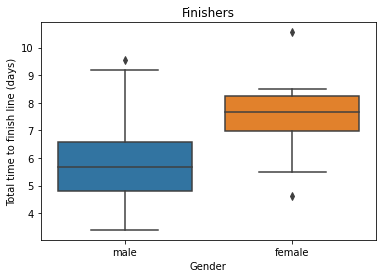

In [26]:
#print(finishers_mv.groupby("Gender").median())
sns.boxplot(data=finishers_mv, y="Race_time_days", x="Gender")
plt.title("Finishers")
plt.ylabel("Total time to finish line (days)")
plt.savefig('./figures/Finishers_total_time.png')
plt.show()

-----------------------------ANALYSIS DNF'ers: days to give up point-----------------------------

In [27]:
DNF_mv = men_vs_women[men_vs_women.Status == "DNF"] #dataframe with all riders that did not finish
DNF_mv[["Race_time_days", "Gender"]].groupby("Gender").describe() # describe

Race_time_days                                                    \
                count      mean       std       min       25%       50%   
Gender                                                                    
female            6.0  2.692593  1.610660  0.413889  2.259722  2.387153   
male             81.0  2.101920  1.455236  0.000000  1.195139  2.053472   

                            
             75%       max  
Gender                      
female  3.177083  5.309722  
male    2.531944  7.136806

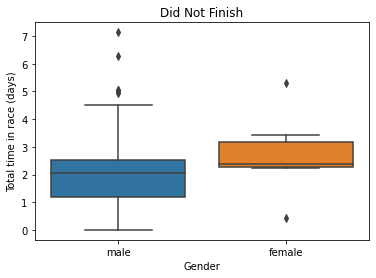

In [28]:
#print(DNF.groupby("Gender").median())
sns.boxplot(data=DNF_mv, y="Race_time_days", x="Gender")
plt.title("Did Not Finish")
plt.ylabel("Total time in race (days)")
plt.savefig("./figures/DNF_total_time.png")
plt.show()

------------------------ANALYSIS DNF: at what point do men and women give up?------------------------

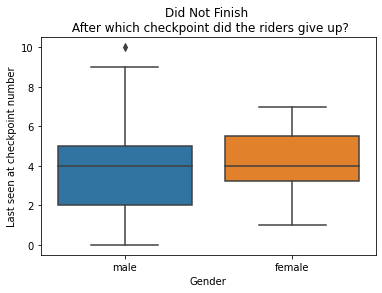

In [29]:
sns.boxplot(data=DNF_mv, y="Last_seen_place", x="Gender")
plt.title("Did Not Finish \n After which checkpoint did the riders give up?")
plt.ylabel("Last seen at checkpoint number")
plt.savefig("./figures/DNF_checkpoint_giveup.png")
plt.show()

PLOT THE DNF PLOTS NEXT TO EACH OTHER

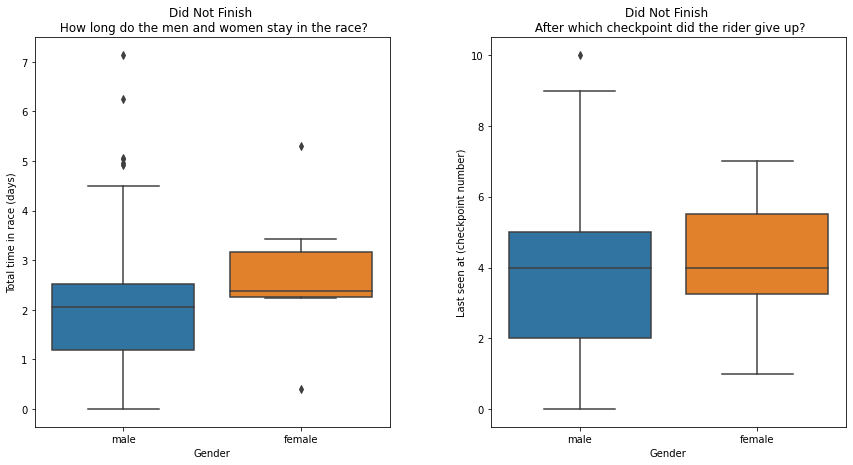

In [30]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
fig.tight_layout(w_pad=7)

# Plot the histogram using a different number of bins
plt.sca(ax[0])
sns.boxplot(data=DNF_mv, y="Race_time_days", x="Gender")
plt.title("Did Not Finish \n How long do the men and women stay in the race?")
plt.ylabel("Total time in race (days)")


plt.sca(ax[1])
sns.boxplot(data=DNF_mv, y="Last_seen_place", x="Gender")
plt.title("Did Not Finish \n After which checkpoint did the rider give up?")
plt.ylabel("Last seen at (checkpoint number)")

plt.savefig('./figures/DNF_days_checkpoints.png')
plt.show();


-------------------ANALYIS: GIVE UP PERCENTAGE: men versus women -----------------

In [31]:
women=men_vs_women[men_vs_women.Gender == "female"]
men=men_vs_women[men_vs_women.Gender == "male"]

In [32]:
women.groupby("Status").count()
men.groupby("Status").count()

women_perc_drop = 6/(6+12)*100
men_perc_drop = 81/(81+137)*100

print("Percentage women that drop: \n", women_perc_drop, "\nPercentage men that drop: \n", men_perc_drop) #men drop more often

Percentage women that drop: 
 33.33333333333333 
Percentage men that drop: 
 37.15596330275229


------- DEMONSTRATION: why displot or KDE don't work as well as the boxplot--------

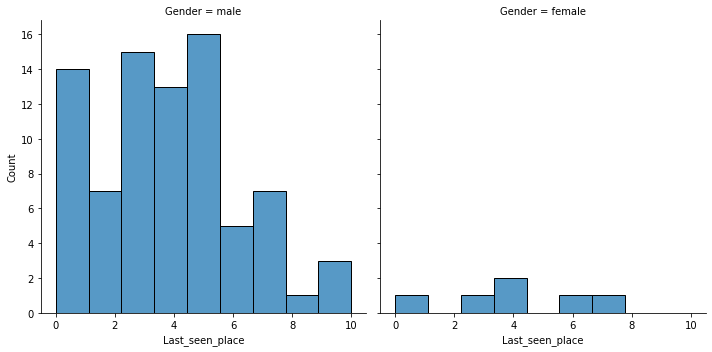

In [34]:
sns.displot(data=DNF_mv, x="Last_seen_place", col="Gender", multiple = "dodge")
plt.savefig("./figures/histogram_DNF_checkpoint_giveup")
plt.show();

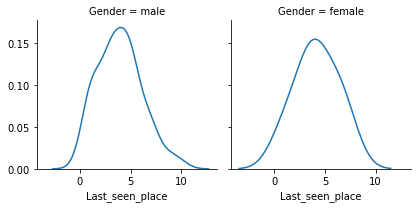

In [35]:
sns.FacetGrid(data = DNF_mv, col = "Gender").map(sns.kdeplot, "Last_seen_place")
#plt.title("Did Not Finish \n After which checkpoint did the rider give up?")
plt.savefig('./figures/kdeplot_checkpoint_giveup')
plt.show();

# ANALYIS: SOLO RIDERS VERSUS DUOS

Duo riders can take turns riding in front (letting the other shelter from the wind). This could mean they are faster, is this the case?

Conclusion: Duo riders seem to get the worst of both worlds, riding slower than solo riders.

In [36]:
solo_vs_pair = riders.groupby(["Gender", "Solo or Duo", "Last_seen_place"]).median().reset_index()
solo_vs_pair.head()

,Gender,Solo or Duo,Last_seen_place,Place,Stretch_1,Stretch_2,Stretch_3,Stretch_4,Stretch_5,Stretch_6,Stretch_7,Stretch_8,Stretch_9,Stretch_10,Race_time_sec,Race_time_hours,Race_time_days
0,female,Duo,7,999.0,26400.0,100440.0,53880.0,25380.0,141480.0,NaN,NaN,NaN,NaN,NaN,460320.0,127.866667,5.327778
1,female,Duo,10,10.0,27540.0,99780.0,52020.0,26040.0,85620.0,90360.0,37200.0,96630.0,85320.0,95700.0,638940.0,177.483333,7.395139
2,female,Solo,1,999.0,35760.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35760.0,9.933333,0.413889
3,female,Solo,3,999.0,27660.0,94260.0,71460.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,193380.0,53.716667,2.238194
4,female,Solo,4,999.0,26190.0,121500.0,20820.0,79620.0,NaN,NaN,NaN,NaN,NaN,NaN,248130.0,68.925000,2.871875


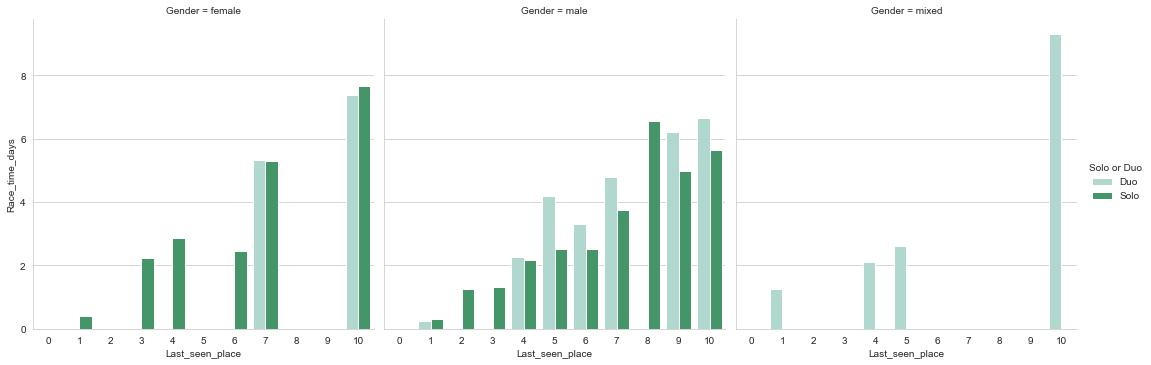

In [37]:
sns.set_style("whitegrid")

sns.catplot(data=solo_vs_pair, x="Last_seen_place", y="Race_time_days", col="Gender", hue="Solo or Duo", kind="bar", palette="BuGn")
plt.savefig("./figures/solo_vs_duo")
plt.show();

# plot improvement: put gender = mixed in plot with women

# WEATHER DATA CLEANING AND WRANGLING
To add the weather data to the riders information, we have to first transform the riders info. 
The riders dataframe should be melted (made longer) so that all rider has a row for each checkpoint (11 rows in total).
The two dataframes will have to be merged by: station(string) and date(string). 

In [38]:
riders.columns

Index(['Place', 'Firstname', 'Lastname', 'Gender', 'Solo or Duo', 'Status',
       'StartDate', 'Checkpoint_1', 'Checkpoint_2', 'Checkpoint_3',
       'Checkpoint_4', 'Checkpoint_5', 'Checkpoint_6', 'Checkpoint_7',
       'Checkpoint_8', 'Checkpoint_9', 'Checkpoint_fin', 'Last_seen_place',
       'Last_seen_date', 'Stretch_1', 'Stretch_2', 'Stretch_3', 'Stretch_4',
       'Stretch_5', 'Stretch_6', 'Stretch_7', 'Stretch_8', 'Stretch_9',
       'Stretch_10', 'Race_time', 'Race_time_sec', 'Race_time_hours',
       'Race_time_days', 'Solo_or_Duo'],
      dtype='object')

#### Put '-' in Firstname column if nan
I need this to be able to make a unique ID

In [39]:
riders["Firstname"] = riders["Firstname"].fillna('-')

In [40]:
#Later on we need a ID per rider, append ID to dataframe (mind recurring riders!)
riders["ID"] = riders["Firstname"] + '_' + riders["Lastname"] + '_' + riders["StartDate"].apply(lambda x : str(x)[0:4])

#I need a date column to use as id in the melted table. I fill it with the startdate for now and change it to the true value later on. 
riders["date"] = riders["StartDate"] 
riders.tail()

,Place,Firstname,Lastname,Gender,Solo or Duo,Status,StartDate,Checkpoint_1,Checkpoint_2,Checkpoint_3,...,Stretch_8,Stretch_9,Stretch_10,Race_time,Race_time_sec,Race_time_hours,Race_time_days,Solo_or_Duo,ID,date
270,2,-,van Rijswijk - van den Broek,mixed,Duo,Finisher,2021-04-30 08:15:00,2021-04-30 15:30:00,2021-05-01 16:16:00,2021-05-01 19:55:00,...,162720.0,80160.0,99300.0,9 days 07:15:00,803700.0,223.250000,9.302083,Duo,-_van Rijswijk - van den Broek_2021,2021-04-30 08:15:00
271,999,-,Cullen - Driedonks,male,Duo,DNF,2021-05-01 06:15:00,2021-05-01 12:40:00,2021-05-02 00:59:00,2021-05-02 04:17:00,...,NaN,NaN,NaN,1 days 12:31:00,131460.0,36.516667,1.521528,Duo,-_Cullen - Driedonks_2021,2021-05-01 06:15:00
272,999,-,Harder - Joosten,male,Duo,DNF,2021-04-30 08:15:00,2021-04-30 15:17:00,2021-05-01 11:53:00,2021-05-01 16:03:00,...,NaN,NaN,NaN,2 days 13:42:00,222120.0,61.700000,2.570833,Duo,-_Harder - Joosten_2021,2021-04-30 08:15:00
273,999,-,Bisschops - Wiegel,mixed,Duo,DNF,2021-04-30 06:30:00,2021-04-30 13:53:00,2021-05-01 11:39:00,2021-05-01 16:00:00,...,NaN,NaN,NaN,2 days 14:43:00,225780.0,62.716667,2.613194,Duo,-_Bisschops - Wiegel_2021,2021-04-30 06:30:00
274,999,-,Verweij - Hoskam,mixed,Duo,DNF,2021-04-30 08:15:00,2021-04-30 14:27:00,2021-05-01 12:38:00,2021-05-01 15:38:00,...,NaN,NaN,NaN,2 days 02:59:00,183540.0,50.983333,2.124306,Duo,-_Verweij - Hoskam_2021,2021-04-30 08:15:00


In [41]:
#all riders now have 10 rows, one for each stretch.
riders_melt = pd.melt(riders, id_vars =['Firstname', "Lastname", "Gender", "Solo or Duo", "Status", "Last_seen_place", "ID", 'StartDate', 'Checkpoint_1', 'Checkpoint_2', 'Checkpoint_3',
       'Checkpoint_4', 'Checkpoint_5', 'Checkpoint_6', 'Checkpoint_7','Checkpoint_8', 'Checkpoint_9', 'Checkpoint_fin', 'date'], value_vars =['Stretch_1', 'Stretch_2', 'Stretch_3', 'Stretch_4','Stretch_5', 'Stretch_6', 'Stretch_7', 'Stretch_8', 'Stretch_9','Stretch_10'])
riders_melt.tail()

,Firstname,Lastname,Gender,Solo or Duo,Status,Last_seen_place,ID,StartDate,Checkpoint_1,Checkpoint_2,...,Checkpoint_4,Checkpoint_5,Checkpoint_6,Checkpoint_7,Checkpoint_8,Checkpoint_9,Checkpoint_fin,date,variable,value
2745,-,van Rijswijk - van den Broek,mixed,Duo,Finisher,10,-_van Rijswijk - van den Broek_2021,2021-04-30 08:15:00,2021-04-30 15:30:00,2021-05-01 16:16:00,...,2021-05-02 16:42:00,2021-05-03 13:18:00,2021-05-05 09:40:00,2021-05-05 16:27:00,2021-05-07 13:39:00,2021-05-08 11:55:00,2021-05-09 15:30:00,2021-04-30 08:15:00,Stretch_10,99300.0
2746,-,Cullen - Driedonks,male,Duo,DNF,4,-_Cullen - Driedonks_2021,2021-05-01 06:15:00,2021-05-01 12:40:00,2021-05-02 00:59:00,...,2021-05-02 18:46:00,empty,empty,empty,empty,empty,empty,2021-05-01 06:15:00,Stretch_10,NaN
2747,-,Harder - Joosten,male,Duo,DNF,5,-_Harder - Joosten_2021,2021-04-30 08:15:00,2021-04-30 15:17:00,2021-05-01 11:53:00,...,2021-05-02 11:59:00,2021-05-02 21:57:00,empty,empty,empty,empty,empty,2021-04-30 08:15:00,Stretch_10,NaN
2748,-,Bisschops - Wiegel,mixed,Duo,DNF,5,-_Bisschops - Wiegel_2021,2021-04-30 06:30:00,2021-04-30 13:53:00,2021-05-01 11:39:00,...,2021-05-02 10:25:00,2021-05-02 21:13:00,empty,empty,empty,empty,empty,2021-04-30 06:30:00,Stretch_10,NaN
2749,-,Verweij - Hoskam,mixed,Duo,DNF,4,-_Verweij - Hoskam_2021,2021-04-30 08:15:00,2021-04-30 14:27:00,2021-05-01 12:38:00,...,2021-05-02 11:14:00,empty,empty,empty,empty,empty,empty,2021-04-30 08:15:00,Stretch_10,NaN


In [42]:
#add a column with the weather station that should be used to get the weatherdata using this function:

def station(checkpoint):
    if checkpoint == "Stretch_1":
        station = "DeBilt"
        return station
    if checkpoint == 'Stretch_2':
        station = "Twenthe"
        return station
    if checkpoint == 'Stretch_3':
        station = "Eelde"
        return station
    if checkpoint == 'Stretch_4':
        station = "Lauwersoog"
        return station
    if checkpoint == 'Stretch_5':
        station = "Lelystad"
        return station
    if checkpoint == 'Stretch_6':
        station = "Den Helder"
        return station
    if checkpoint == 'Stretch_7':
        station = "HoekvanHolland"
        return station
    if checkpoint == 'Stretch_8':
        station = "Vlissingen"
        return station
    if checkpoint == 'Stretch_9':
        station = "Ell"
        return station
    if checkpoint == 'Stretch_10':
        station = "Arcen"
        return station
    else:
        error_mes = "AAA" # this will show up due to the StartDate variable
        return error_mes

In [43]:
riders_melt["Station"] = riders_melt["variable"].apply(station)
print(type(riders_melt["value"][0]))
riders_melt.head()

<class 'numpy.float64'>


,Firstname,Lastname,Gender,Solo or Duo,Status,Last_seen_place,ID,StartDate,Checkpoint_1,Checkpoint_2,...,Checkpoint_5,Checkpoint_6,Checkpoint_7,Checkpoint_8,Checkpoint_9,Checkpoint_fin,date,variable,value,Station
0,Joris,Cosyn,male,Solo,Finisher,10,Joris_Cosyn_2018,2018-05-01 08:00:00,2018-05-01 13:38:00,2018-05-02 01:17:00,...,2018-05-02 16:02:00,2018-05-03 06:28:00,2018-05-03 11:36:00,2018-05-04 05:54:00,2018-05-04 19:20:00,2018-05-05 14:24:00,2018-05-01 08:00:00,Stretch_1,20280.0,DeBilt
1,Tjerk,Bakker,male,Solo,Finisher,10,Tjerk_Bakker_2018,2018-05-01 08:00:00,2018-05-01 14:35:00,2018-05-02 09:15:00,...,2018-05-03 07:01:00,2018-05-03 14:34:00,2018-05-03 19:30:00,2018-05-04 16:03:00,2018-05-05 08:59:00,2018-05-05 18:48:00,2018-05-01 08:00:00,Stretch_1,23700.0,DeBilt
2,Colin,James,male,Solo,Finisher,10,Colin_James_2018,2018-05-01 08:00:00,2018-05-01 14:08:00,2018-05-02 08:32:00,...,2018-05-03 04:11:00,2018-05-03 12:32:00,2018-05-03 17:34:00,2018-05-04 12:10:00,2018-05-05 07:54:00,2018-05-05 19:22:00,2018-05-01 08:00:00,Stretch_1,22080.0,DeBilt
3,Jason,Schreurs,male,Solo,Finisher,10,Jason_Schreurs_2018,2018-05-01 08:00:00,2018-05-01 13:27:00,2018-05-02 10:08:00,...,2018-05-03 08:16:00,2018-05-03 14:51:00,2018-05-03 19:30:00,2018-05-04 16:35:00,2018-05-05 11:05:00,2018-05-05 21:30:00,2018-05-01 08:00:00,Stretch_1,19620.0,DeBilt
4,Erik,Wallinga,male,Solo,Finisher,10,Erik_Wallinga_2018,2018-05-01 08:00:00,2018-05-01 14:25:00,2018-05-02 04:13:00,...,2018-05-02 20:00:00,2018-05-03 14:13:00,2018-05-03 18:40:00,2018-05-04 20:22:00,2018-05-05 09:53:00,2018-05-05 22:39:00,2018-05-01 08:00:00,Stretch_1,23100.0,DeBilt


In [44]:
#add a column with the date.

date_for_stretch = []

for i in range (len(riders_melt)):
    if riders_melt["variable"][i] == 'Stretch_1':
        date = riders_melt["StartDate"][i]
        date_for_stretch.append(date)
    if riders_melt["variable"][i] == 'Stretch_2':
        date = riders_melt["Checkpoint_1"][i]
        date_for_stretch.append(date)
    if riders_melt["variable"][i] == 'Stretch_3':
        date = riders_melt["Checkpoint_2"][i]
        date_for_stretch.append(date)
    if riders_melt["variable"][i] == 'Stretch_4':
        date = riders_melt["Checkpoint_3"][i]
        date_for_stretch.append(date)
    if riders_melt["variable"][i] == 'Stretch_5':
        date = riders_melt["Checkpoint_4"][i]
        date_for_stretch.append(date)
    if riders_melt["variable"][i] == 'Stretch_6':
        date = riders_melt["Checkpoint_5"][i]
        date_for_stretch.append(date)
    if riders_melt["variable"][i] == 'Stretch_7':
        date = riders_melt["Checkpoint_6"][i]
        date_for_stretch.append(date)
    if riders_melt["variable"][i] == 'Stretch_8':
        date = riders_melt["Checkpoint_7"][i]
        date_for_stretch.append(date)
    if riders_melt["variable"][i] == 'Stretch_9':
        date = riders_melt["Checkpoint_8"][i]
        date_for_stretch.append(date)
    if riders_melt["variable"][i] == 'Stretch_10':
        date = riders_melt["Checkpoint_9"][i]
        date_for_stretch.append(date)


In [45]:
riders_melt["date"]=date_for_stretch #this is where I replace the date values (which were filled with start date) with their true value

In [46]:
riders_melt.head() #date is no longer startdate

,Firstname,Lastname,Gender,Solo or Duo,Status,Last_seen_place,ID,StartDate,Checkpoint_1,Checkpoint_2,...,Checkpoint_5,Checkpoint_6,Checkpoint_7,Checkpoint_8,Checkpoint_9,Checkpoint_fin,date,variable,value,Station
0,Joris,Cosyn,male,Solo,Finisher,10,Joris_Cosyn_2018,2018-05-01 08:00:00,2018-05-01 13:38:00,2018-05-02 01:17:00,...,2018-05-02 16:02:00,2018-05-03 06:28:00,2018-05-03 11:36:00,2018-05-04 05:54:00,2018-05-04 19:20:00,2018-05-05 14:24:00,2018-05-01 08:00:00,Stretch_1,20280.0,DeBilt
1,Tjerk,Bakker,male,Solo,Finisher,10,Tjerk_Bakker_2018,2018-05-01 08:00:00,2018-05-01 14:35:00,2018-05-02 09:15:00,...,2018-05-03 07:01:00,2018-05-03 14:34:00,2018-05-03 19:30:00,2018-05-04 16:03:00,2018-05-05 08:59:00,2018-05-05 18:48:00,2018-05-01 08:00:00,Stretch_1,23700.0,DeBilt
2,Colin,James,male,Solo,Finisher,10,Colin_James_2018,2018-05-01 08:00:00,2018-05-01 14:08:00,2018-05-02 08:32:00,...,2018-05-03 04:11:00,2018-05-03 12:32:00,2018-05-03 17:34:00,2018-05-04 12:10:00,2018-05-05 07:54:00,2018-05-05 19:22:00,2018-05-01 08:00:00,Stretch_1,22080.0,DeBilt
3,Jason,Schreurs,male,Solo,Finisher,10,Jason_Schreurs_2018,2018-05-01 08:00:00,2018-05-01 13:27:00,2018-05-02 10:08:00,...,2018-05-03 08:16:00,2018-05-03 14:51:00,2018-05-03 19:30:00,2018-05-04 16:35:00,2018-05-05 11:05:00,2018-05-05 21:30:00,2018-05-01 08:00:00,Stretch_1,19620.0,DeBilt
4,Erik,Wallinga,male,Solo,Finisher,10,Erik_Wallinga_2018,2018-05-01 08:00:00,2018-05-01 14:25:00,2018-05-02 04:13:00,...,2018-05-02 20:00:00,2018-05-03 14:13:00,2018-05-03 18:40:00,2018-05-04 20:22:00,2018-05-05 09:53:00,2018-05-05 22:39:00,2018-05-01 08:00:00,Stretch_1,23100.0,DeBilt


In [47]:
# drop checkpoint dates - don't use them here
riders_melt = riders_melt.drop(['Checkpoint_1', 'Checkpoint_2','Checkpoint_3', 'Checkpoint_4', 'Checkpoint_5', 'Checkpoint_6',
       'Checkpoint_7', 'Checkpoint_8', 'Checkpoint_9', 'Checkpoint_fin'], axis = 1)

In [48]:
riders_melt.head(6)

,Firstname,Lastname,Gender,Solo or Duo,Status,Last_seen_place,ID,StartDate,date,variable,value,Station
0,Joris,Cosyn,male,Solo,Finisher,10,Joris_Cosyn_2018,2018-05-01 08:00:00,2018-05-01 08:00:00,Stretch_1,20280.0,DeBilt
1,Tjerk,Bakker,male,Solo,Finisher,10,Tjerk_Bakker_2018,2018-05-01 08:00:00,2018-05-01 08:00:00,Stretch_1,23700.0,DeBilt
2,Colin,James,male,Solo,Finisher,10,Colin_James_2018,2018-05-01 08:00:00,2018-05-01 08:00:00,Stretch_1,22080.0,DeBilt
3,Jason,Schreurs,male,Solo,Finisher,10,Jason_Schreurs_2018,2018-05-01 08:00:00,2018-05-01 08:00:00,Stretch_1,19620.0,DeBilt
4,Erik,Wallinga,male,Solo,Finisher,10,Erik_Wallinga_2018,2018-05-01 08:00:00,2018-05-01 08:00:00,Stretch_1,23100.0,DeBilt
5,Ralph,Cullen,male,Solo,Finisher,10,Ralph_Cullen_2018,2018-05-01 08:00:00,2018-05-01 08:00:00,Stretch_1,21840.0,DeBilt


In [49]:
print(type(riders_melt["value"][0]))
print(type(weather["date"][0]))


#create string-date column, %Y-%m-%d only (discard the time)
riders_melt["date"]= riders_melt["date"].apply(lambda x : str(x)[0:10])

print(type(riders_melt["date"][0]))

riders_melt.head()
weather.head()

<class 'numpy.float64'>
<class 'str'>
<class 'str'>


,Unnamed: 0,Station,temp,rain_mm,rain_hrs,wind_spd,date
0,0,DeBilt,7.9,9.2,8.3,3,2018-05-01
1,1,DeBilt,10.9,0.2,1.4,3,2018-05-02
2,2,DeBilt,10.4,0.0,0.0,2,2018-05-03
3,3,DeBilt,11.9,0.0,0.0,2,2018-05-04
4,4,DeBilt,14.7,0.0,0.0,2,2018-05-05


In [50]:
#key1 = Station; key2=date (value/variable) 
riders_weather = pd.merge(riders_melt, weather, on=['Station','date'], how="left")

print(len(riders_weather), len(riders_melt), len(weather)) #check if all rows are still present

# riders_weather.iloc[[0,1,7,9,32,50,67,68,100,150,151,300,301,350,351,505,507,610,611] , :] # have a look, seems to go alright

2750 2750 370


In [51]:
riders_weather.head(2)

,Firstname,Lastname,Gender,Solo or Duo,Status,Last_seen_place,ID,StartDate,date,variable,value,Station,Unnamed: 0,temp,rain_mm,rain_hrs,wind_spd
0,Joris,Cosyn,male,Solo,Finisher,10,Joris_Cosyn_2018,2018-05-01 08:00:00,2018-05-01,Stretch_1,20280.0,DeBilt,0.0,7.9,9.2,8.3,3.0
1,Tjerk,Bakker,male,Solo,Finisher,10,Tjerk_Bakker_2018,2018-05-01 08:00:00,2018-05-01,Stretch_1,23700.0,DeBilt,0.0,7.9,9.2,8.3,3.0


In [52]:
riders_weather = riders_weather.drop("Unnamed: 0", axis =1)

In [53]:
riders_weather.head()

,Firstname,Lastname,Gender,Solo or Duo,Status,Last_seen_place,ID,StartDate,date,variable,value,Station,temp,rain_mm,rain_hrs,wind_spd
0,Joris,Cosyn,male,Solo,Finisher,10,Joris_Cosyn_2018,2018-05-01 08:00:00,2018-05-01,Stretch_1,20280.0,DeBilt,7.9,9.2,8.3,3.0
1,Tjerk,Bakker,male,Solo,Finisher,10,Tjerk_Bakker_2018,2018-05-01 08:00:00,2018-05-01,Stretch_1,23700.0,DeBilt,7.9,9.2,8.3,3.0
2,Colin,James,male,Solo,Finisher,10,Colin_James_2018,2018-05-01 08:00:00,2018-05-01,Stretch_1,22080.0,DeBilt,7.9,9.2,8.3,3.0
3,Jason,Schreurs,male,Solo,Finisher,10,Jason_Schreurs_2018,2018-05-01 08:00:00,2018-05-01,Stretch_1,19620.0,DeBilt,7.9,9.2,8.3,3.0
4,Erik,Wallinga,male,Solo,Finisher,10,Erik_Wallinga_2018,2018-05-01 08:00:00,2018-05-01,Stretch_1,23100.0,DeBilt,7.9,9.2,8.3,3.0


#  ANALYSIS: DOES WEATHER AFFECT THE RIDERS?

weather parameters: temperature, rain in mm, rain in hours, windspeed.

Hypothesis:
<ul>
    <li> Bad weather increase the time in race for finishers </li>
    <li> Bad weather decreases the tim in race for DNF'ers </li>
</ul>

Analyse finishers and DNF'ers seperately.

Conclusion finishers: 
<ul> 
    <li> more hours of rain is correlated with longer times in race, more so than mm of rain </li>
    <li> correlation with temperature seems to be disturbed by 1 edition that was held in august due to corona (2020) 
    <li> wind speed does not show a huge correlation, possibly due to bad quality wind speed data (average windspeed seems to low) and due to the fact that there is no data on wind direction </li>
</ul>

Conclusion DNF'ers: 

probably better to look at the correlation between the weather and after which checkpoint the riders give up, instead of the total time in race.

---------------ANALYSIS: WEATHER AND FINISHERS ------------

In [54]:
Finishers_weather = riders_weather[riders_weather.Status=="Finisher"]
corr = Finishers_weather.corr()
corr

,Last_seen_place,value,temp,rain_mm,rain_hrs,wind_spd
Last_seen_place,1.000000,-0.057607,0.087536,0.029345,0.019015,0.036423
value,-0.057607,1.000000,-0.111153,-0.060231,0.027935,0.021083
temp,0.087536,-0.111153,1.000000,0.154713,0.003363,-0.033092
rain_mm,0.029345,-0.060231,0.154713,1.000000,0.909879,0.492301
rain_hrs,0.019015,0.027935,0.003363,0.909879,1.000000,0.459188
wind_spd,0.036423,0.021083,-0.033092,0.492301,0.459188,1.000000


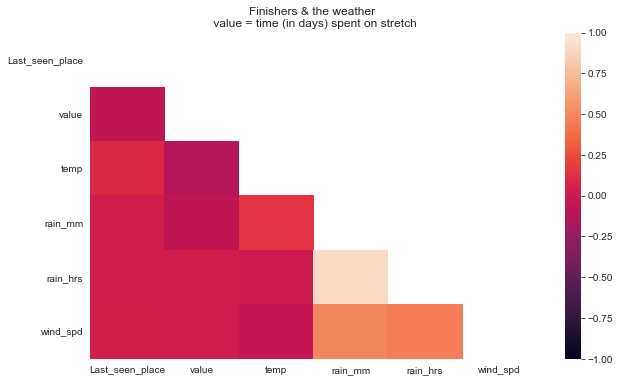

In [55]:
fig = plt.figure(figsize=(10, 6))
mask = np.triu(np.ones_like(corr))
sns.heatmap(corr, mask=mask, vmin=-1, vmax=1)
plt.title("Finishers & the weather \n value = time (in days) spent on stretch")
plt.savefig('./figures/finishers_weather')
plt.show();

# when analysing the data of all finishers like this, no real correlation occurs. Which makes sense (see comment in next cell)

In [56]:
#Each person get to deal with different weather-circumstances: the riders don't ride together and get dispersed along the route. Use mean temps, rain, wind and value per person. 
ind_fin_weather = Finishers_weather.groupby("ID").sum() #you need the sum of the racetime (value) rain_mm and rain_hrs, but the sum temp and sum wind_spd are not meaningful so will use averages instead (calculated below)
ind_fin_weather["Last_seen_place"] = (ind_fin_weather["Last_seen_place"])

ind_fin_weather["temp_avg"] = ind_fin_weather["temp"]/10
ind_fin_weather["wind_spd_avg"] = ind_fin_weather["wind_spd"]/10

 #remove the not used temp and wind column for a prettier plot
ind_fin_weather.drop("wind_spd", axis =1, inplace=True)
ind_fin_weather.drop("temp", axis =1, inplace=True)
ind_fin_weather.tail()

,Last_seen_place,value,rain_mm,rain_hrs,temp_avg,wind_spd_avg
ID,,,,,,
unknown_Frans-Frans_2020,100,408600.0,19.9,9.3,14.68,2.1
unknown_Hippy_2019,100,196260.0,20.7,19.1,6.88,1.6
unknown_Leitner-Finger_2020,100,489600.0,32.1,20.3,14.83,2.3
unknown_Mulders-Croonen_2020,100,433320.0,26.4,17.6,13.30,2.0
unknown_Raboen - Raboen_2018,100,492240.0,19.0,20.8,11.31,2.5


In [57]:
corr_ind = ind_fin_weather.corr()
corr_ind

,Last_seen_place,value,rain_mm,rain_hrs,temp_avg,wind_spd_avg
Last_seen_place,1.000000,0.030971,0.166896,0.124734,0.140524,0.230413
value,0.030971,1.000000,0.236701,0.455540,-0.139367,0.264429
rain_mm,0.166896,0.236701,1.000000,0.727386,0.497129,0.261953
rain_hrs,0.124734,0.455540,0.727386,1.000000,-0.065205,0.445592
temp_avg,0.140524,-0.139367,0.497129,-0.065205,1.000000,-0.052905
wind_spd_avg,0.230413,0.264429,0.261953,0.445592,-0.052905,1.000000


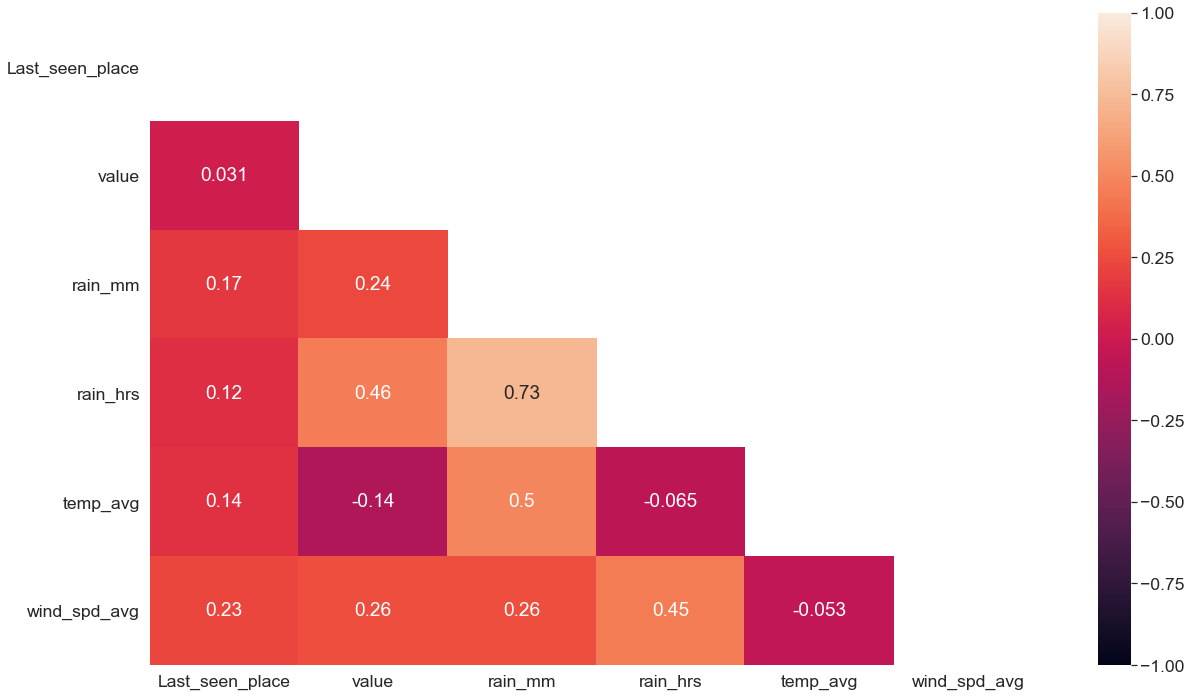

In [58]:
fig = plt.figure(figsize=(20, 12)) # make it big so the savefig saves the whole graph
sns.set(font_scale=1.6)
mask = np.triu(np.ones_like(corr_ind))
sns.heatmap(corr_ind, mask=mask, vmin=-1, vmax=1, annot=True).set_facecolor('xkcd:white')
#plt.title("Finishers & the weather \n value = time (in days) spent on total ride")
plt.savefig('./figures/finishers_weather_totalride')
plt.show();

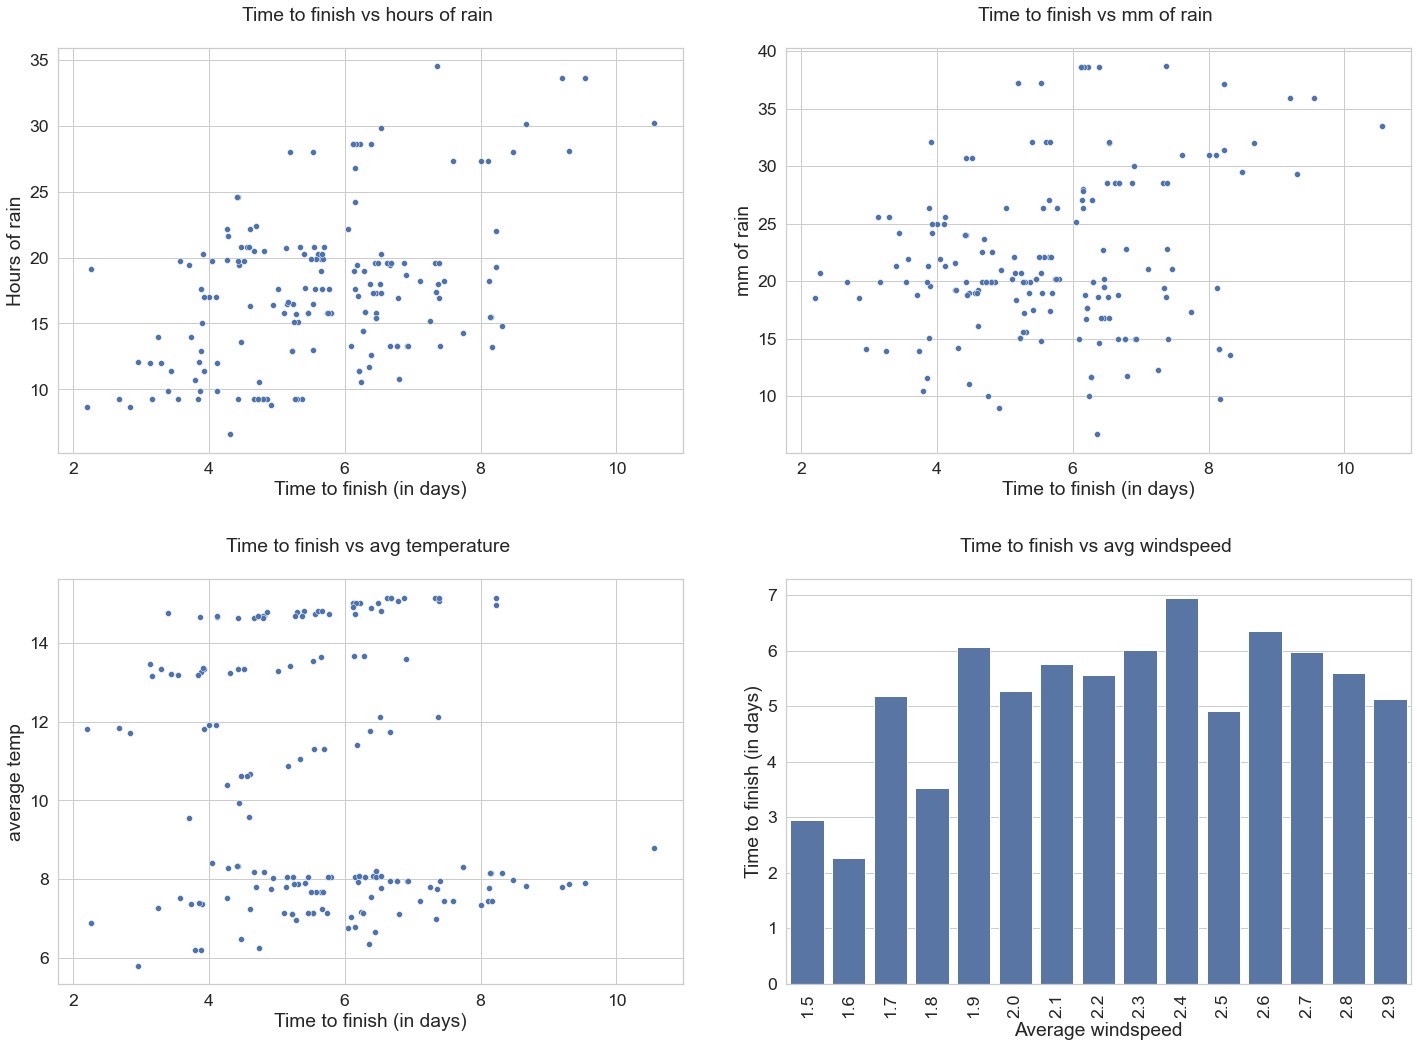

In [59]:
# look at correlation in more detail:

sns.set_style("whitegrid")
ind_fin_weather["days_in_race"] =ind_fin_weather["value"]/(60*60*24)

fig, ax = plt.subplots(2,2, figsize = (20,14))
fig.tight_layout(w_pad=3, h_pad=5)

# Plot the histogram using a different number of bins
plt.sca(ax[0][0])
sns.scatterplot(x="days_in_race", y="rain_hrs", data=ind_fin_weather)
plt.title("Time to finish vs hours of rain \n")
plt.xlabel("Time to finish (in days)")
plt.ylabel("Hours of rain")


plt.sca(ax[0][1])
sns.scatterplot(x="days_in_race", y="rain_mm", data=ind_fin_weather)
plt.title("Time to finish vs mm of rain \n")
plt.xlabel("Time to finish (in days)")
plt.ylabel("mm of rain")

plt.sca(ax[1][0])
sns.scatterplot(x="days_in_race", y="temp_avg", data=ind_fin_weather)
plt.title("Time to finish vs avg temperature \n")
plt.xlabel("Time to finish (in days)")
plt.ylabel("average temp")


plt.sca(ax[1][1])
bin_nr = np.sqrt(len(ind_fin_weather))
sns.barplot(y="days_in_race", x="wind_spd_avg", ci=None, data=ind_fin_weather, color = 'b')
plt.title("Time to finish vs avg windspeed \n")
plt.ylabel("Time to finish (in days)")
plt.xlabel("Average windspeed")
plt.xticks(rotation=90)
plt.savefig('./figures/finishers_rain_wind')



plt.show();

----------------------ANALYSIS: WEATHER AND DNF'ers--------------------

In [60]:
#split the DNF'ers from the finishers
DNF_weather = riders_weather[riders_weather.Status=="DNF"]

DNF_weather.corr()

,Last_seen_place,value,temp,rain_mm,rain_hrs,wind_spd
Last_seen_place,1.000000,0.041580,0.062402,0.030395,0.046346,0.178163
value,0.041580,1.000000,-0.074680,-0.074308,0.005200,0.044680
temp,0.062402,-0.074680,1.000000,0.094285,-0.100046,0.183757
rain_mm,0.030395,-0.074308,0.094285,1.000000,0.898180,0.331574
rain_hrs,0.046346,0.005200,-0.100046,0.898180,1.000000,0.286821
wind_spd,0.178163,0.044680,0.183757,0.331574,0.286821,1.000000


In [61]:
#For DNF you'd need the average of all rain parameters, as you need to adjust them to number of stretches each individual rider fulfilled. 
#As the more checkpoints you take, the more likely you are to encounter a rainy day, so you have to correct for that. 

ind_DNF_weather = DNF_weather.groupby("ID").sum() #you need the sum of the racetime (value) and average rain_mm, rain_hrs, avg temp and wind_spd. will calculate these averages below
ind_DNF_weather["Last_seen_place"] = (ind_DNF_weather["Last_seen_place"])

ind_DNF_weather["rain_hrs_avg"] = ind_DNF_weather["rain_hrs"]/(ind_DNF_weather["Last_seen_place"]/10)
ind_DNF_weather["rain_mm_avg"] = ind_DNF_weather["rain_mm"]/(ind_DNF_weather["Last_seen_place"]/10)
ind_DNF_weather["temp_avg"] = ind_DNF_weather["temp"]/(ind_DNF_weather["Last_seen_place"]/10)
ind_DNF_weather["wind_spd_avg"] = ind_DNF_weather["wind_spd"]/(ind_DNF_weather["Last_seen_place"]/10)

 #remove the not used temp and wind column for a prettier plot
ind_DNF_weather.drop("rain_hrs", axis =1, inplace=True)
ind_DNF_weather.drop("rain_mm", axis =1, inplace=True)
ind_DNF_weather.drop("wind_spd", axis =1, inplace=True)
ind_DNF_weather.drop("temp", axis =1, inplace=True)
ind_DNF_weather.tail()

,Last_seen_place,value,rain_hrs_avg,rain_mm_avg,temp_avg,wind_spd_avg
ID,,,,,,
Wytze_Schuurmans_2019,30,87180.0,1.933333,3.400000,12.266667,2.666667
Yves_Smits_2019,50,204420.0,2.700000,3.540000,10.820000,2.400000
unknown_Casier-Vanbillemont_2020,40,109200.0,0.300000,0.700000,14.450000,2.000000
unknown_Kim - Kim_2018,10,108120.0,9.700000,9.400000,18.800000,6.000000
unknown_Lagerwerf - Meerwijk_2018,60,285540.0,3.233333,3.133333,11.716667,3.000000


In [62]:
corr_ind_DNF = ind_DNF_weather.corr()
corr_ind_DNF

,Last_seen_place,value,rain_hrs_avg,rain_mm_avg,temp_avg,wind_spd_avg
Last_seen_place,1.000000,0.741882,-0.144201,-0.154421,-0.537355,-0.631735
value,0.741882,1.000000,-0.056440,-0.123410,-0.403480,-0.370636
rain_hrs_avg,-0.144201,-0.056440,1.000000,0.970456,0.041091,0.461388
rain_mm_avg,-0.154421,-0.123410,0.970456,1.000000,0.153733,0.448712
temp_avg,-0.537355,-0.403480,0.041091,0.153733,1.000000,0.631103
wind_spd_avg,-0.631735,-0.370636,0.461388,0.448712,0.631103,1.000000


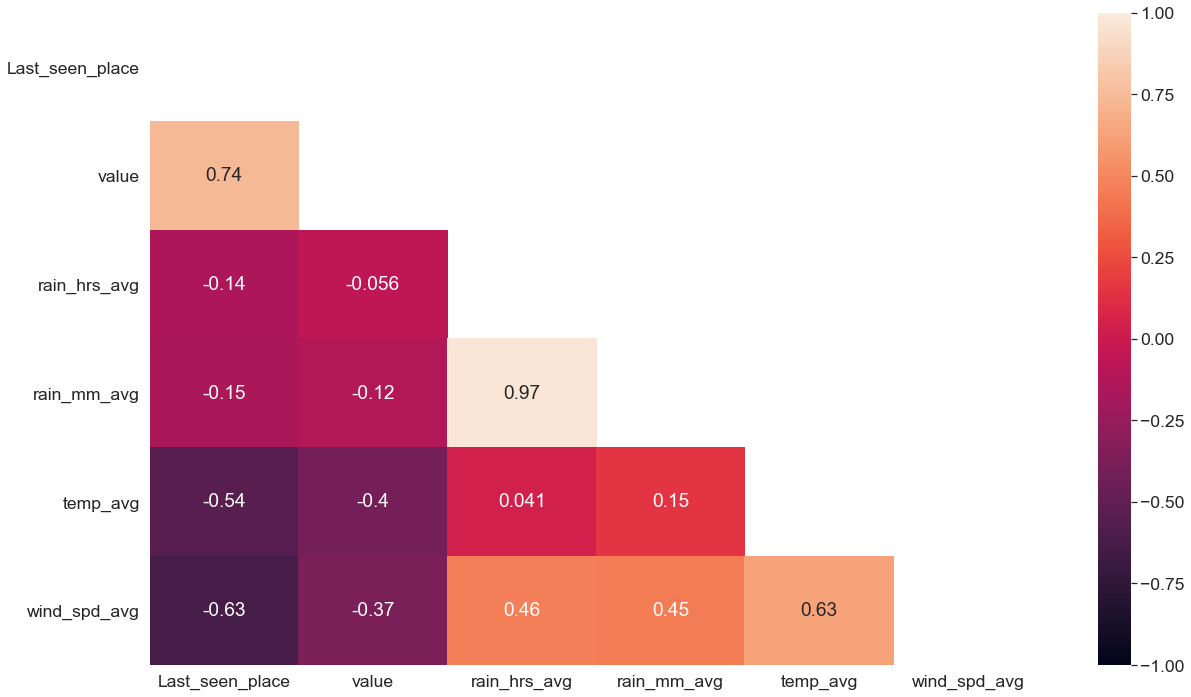

In [63]:
fig = plt.figure(figsize=(20, 12)) # make it big so the savefig saves the whole graph
sns.set(font_scale=1.6)
mask = np.triu(np.ones_like(corr))
sns.heatmap(corr_ind_DNF, mask=mask, vmin=-1, vmax=1, annot=True).set_facecolor('xkcd:white')
#plt.title("Finishers & the weather \n value = time (in days) spent on total ride")
plt.savefig('./figures/DNF_weather_totalride')
plt.show();

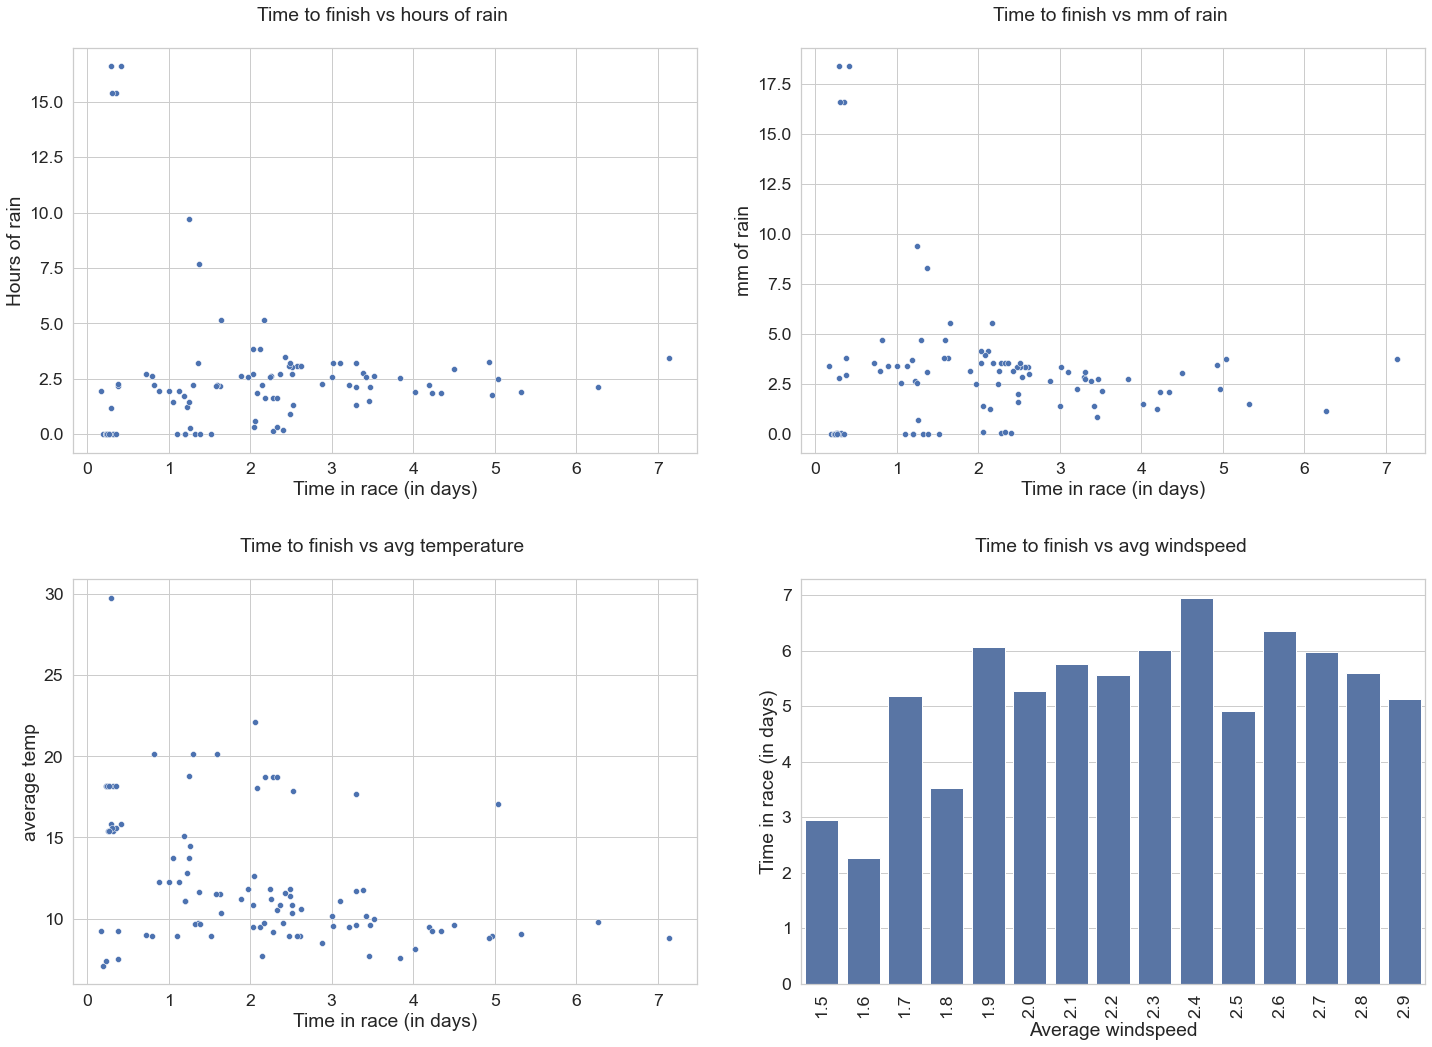

In [64]:
# look into more detail:

sns.set_style("whitegrid")
ind_DNF_weather["days_in_race"] =ind_DNF_weather["value"]/(60*60*24)

fig, ax = plt.subplots(2,2, figsize = (20,14))
fig.tight_layout(w_pad=3, h_pad=5)

# Plot the histogram using a different number of bins
plt.sca(ax[0][0])
sns.scatterplot(x="days_in_race", y="rain_hrs_avg", data=ind_DNF_weather)
plt.title("Time to finish vs hours of rain \n")
plt.xlabel("Time in race (in days)")
plt.ylabel("Hours of rain")


plt.sca(ax[0][1])
sns.scatterplot(x="days_in_race", y="rain_mm_avg", data=ind_DNF_weather)
plt.title("Time to finish vs mm of rain \n")
plt.xlabel("Time in race (in days)")
plt.ylabel("mm of rain")

plt.sca(ax[1][0])
sns.scatterplot(x="days_in_race", y="temp_avg", data=ind_DNF_weather)
plt.title("Time to finish vs avg temperature \n")
plt.xlabel("Time in race (in days)")
plt.ylabel("average temp")


plt.sca(ax[1][1])
bin_nr = np.sqrt(len(ind_DNF_weather))
sns.barplot(y="days_in_race", x="wind_spd_avg", ci=None, data=ind_fin_weather, color = 'b')
plt.title("Time to finish vs avg windspeed \n")
plt.ylabel("Time in race (in days)")
plt.xlabel("Average windspeed")
plt.xticks(rotation=90)
plt.savefig('./figures/DNF_rain_wind')



plt.show();